# Image segmentation with UNET+(Resnet or EfficientNet)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from file_cache import *
from fastai.vision import *
from fastai.callbacks.hooks import *

2020-06-14 21:23:34,628 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/dynamic_unet/


In [3]:
# path = untar_data(URLs.CAMVID)
# path.ls()
path='./input/camvid'

In [4]:
path_lbl = f'{path}/labels'
path_img = f'{path}/images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('input/camvid/images/0016E5_07979.png'),
 PosixPath('input/camvid/images/0016E5_08141.png'),
 PosixPath('input/camvid/images/0006R0_f03360.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('input/camvid/labels/Seq05VD_f04320_P.png'),
 PosixPath('input/camvid/labels/Seq05VD_f03330_P.png'),
 PosixPath('input/camvid/labels/0016E5_08097_P.png')]

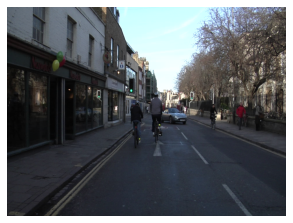

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [8]:
get_y_fn = lambda x: f'{path_lbl}/{x.stem}_P{x.suffix}'

In [9]:
get_y_fn(img_f)

'./input/camvid/labels/0016E5_07979_P.png'

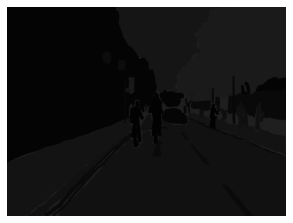

In [10]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

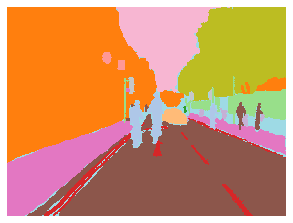

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(f'{path}/codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size #//2
bs = 2
print(size)

[720 960]


In [15]:
!pwd

/share/felix/pj/dynamic_unet


In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

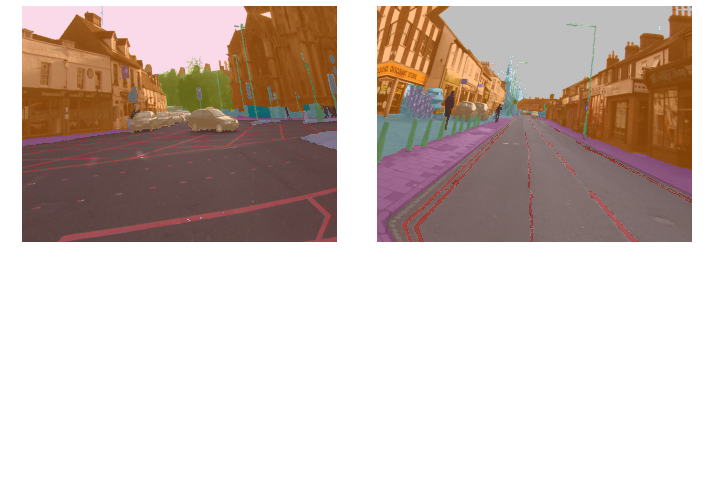

In [18]:
data.show_batch(2, figsize=(10, 7))

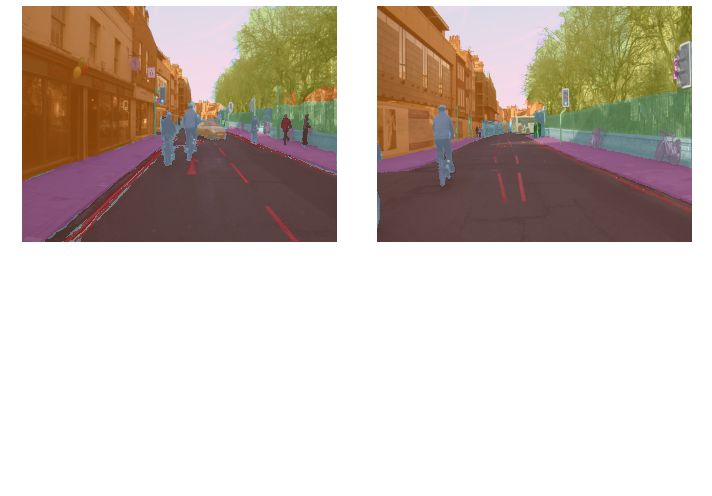

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics = acc_camvid

In [22]:
wd = 1e-2
lr = 3e-3

In [23]:
# create unet
import ipdb
#ipdb.set_trace()
from fastai.vision.learner import cnn_config
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    #if pretrained: learn.freeze()
    print('====')    
    #print(model[2])
    #apply_init(model[2], nn.init.kaiming_normal_)
    return learn


learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd)


learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

====


epoch,train_loss,valid_loss,acc_camvid,time
0,0.806949,0.698844,0.805823,02:32
1,0.593860,0.449624,0.886123,02:27
2,0.657078,0.467381,0.878344,02:32
3,0.598720,0.660275,0.788746,02:31
4,0.636164,0.535271,0.857372,02:31
5,0.570006,0.692788,0.825149,02:30
6,0.540595,0.475159,0.880260,02:30
7,0.503240,0.399799,0.886412,02:30
8,0.503631,0.417932,0.878368,02:29
9,0.369606,0.310055,0.910313,02:30


In [24]:
from file_cache import *
from dynamic_unet.base import DynamicUnet

In [25]:
encoder = nn.Sequential(*list(models.resnet34(pretrained=True).children())[:-2])

unet = to_device( DynamicUnet(encoder, n_classes=32, img_size=size, blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False), 'cuda')
 

learn = Learner(data, unet , metrics=acc_camvid, wd=wd)
learn.split(lambda m: (m[0][6],m[1]) )
#learn.freeze()

learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

   sn       layer    c    w    h               size
2   2        ReLU   64  360  480  (1, 64, 360, 480)
4   4  Sequential   64  180  240  (1, 64, 180, 240)
5   5  Sequential  128   90  120  (1, 128, 90, 120)
6   6  Sequential  256   45   60   (1, 256, 45, 60)
7   7  Sequential  512   23   30   (1, 512, 23, 30)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.824291,0.620620,0.842343,02:31
1,0.586815,0.449258,0.884102,02:32
2,0.606729,0.434064,0.887799,02:31
3,0.592502,0.616889,0.858035,02:31
4,0.545193,0.535633,0.855146,02:30
5,0.592968,0.482019,0.869387,02:30
6,0.547216,0.481762,0.871483,02:31
7,0.554550,0.382317,0.898598,02:30
8,0.497919,0.384965,0.894528,02:30
9,0.358277,0.287012,0.912982,02:30


In [26]:
encoder = nn.Sequential(*list(models.resnet34(pretrained=True).children())[:-2])

unet = to_device( DynamicUnet(encoder, n_classes=32, img_size=size, blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False), 'cuda')
 

learn = Learner(data, unet , metrics=acc_camvid, wd=wd)
learn.split(lambda m: (m[0][4],) )
learn.freeze()

learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

   sn       layer    c    w    h               size
2   2        ReLU   64  360  480  (1, 64, 360, 480)
4   4  Sequential   64  180  240  (1, 64, 180, 240)
5   5  Sequential  128   90  120  (1, 128, 90, 120)
6   6  Sequential  256   45   60   (1, 256, 45, 60)
7   7  Sequential  512   23   30   (1, 512, 23, 30)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.773646,0.604120,0.850630,02:31
1,0.696120,0.622467,0.836875,02:32
2,0.709574,0.538531,0.866952,02:30
3,0.769666,0.692014,0.842223,02:29
4,0.704076,0.739662,0.812231,02:28
5,1.104878,1.095701,0.678904,02:28
6,0.962406,0.960350,0.722773,02:28
7,0.865918,0.816103,0.769851,02:27
8,0.822140,1.003179,0.745691,02:27
9,0.727378,0.687508,0.802857,02:27


In [27]:
#learn.model

In [29]:
#encoder(torch.rand(1,3, 224,224)).shape

In [33]:

def flatten_moduleList(module: nn.Module) -> List[nn.Module]:
    "If the ModuleList can be found in children, flatten it. Since ModuleList can not support hook "
    res_list = []
    for item in module.children():
        if isinstance(item, nn.ModuleList):
            res_list.extend(flatten_moduleList(item))
        else:
            res_list.append(item)
    return res_list

for i in range(3):
    n_classes =32
    in_channels =3 
    def efficient_unet(name='5', in_channels=3):
        from efficientnet_pytorch import EfficientNet
        class EfficientNet_(EfficientNet):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)

            def forward(self, inputs):
                x = self.extract_features(inputs)
                return x
        eff =  EfficientNet_.from_pretrained(f'efficientnet-b{name}', in_channels=in_channels)
        
        moduleList = flatten_moduleList(encoder)
        print(len(moduleList))
        for child in moduleList[:-2]:
            for param in child.parameters():
                param.requires_grad = False
        return eff

    encoder = efficient_unet(i, in_channels=in_channels)
    unet = to_device(
            DynamicUnet(encoder, n_classes=n_classes, img_size=size, blur=True, blur_final=True,
                                    self_attention=False, y_range=None, norm_type=NormType,
                                    last_cross=True,
                                    bottle=False), 'cuda')


    learn = Learner(data, unet , metrics=acc_camvid, wd=wd)

    #print(type(learn.model))
    learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

Loaded pretrained weights for efficientnet-b0
24
    sn                 layer     c    w    h               size
3    3           MBConvBlock    16  360  480  (1, 16, 360, 480)
5    5           MBConvBlock    24  180  240  (1, 24, 180, 240)
7    7           MBConvBlock    40   90  120   (1, 40, 90, 120)
13  13           MBConvBlock   112   45   60   (1, 112, 45, 60)
21  21  MemoryEfficientSwish  1280   22   30  (1, 1280, 22, 30)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.845158,0.740562,0.819856,02:38
1,0.739639,0.614605,0.853020,02:42
2,0.629306,0.583638,0.849292,02:45
3,0.685722,0.558950,0.856122,02:45
4,0.664117,1.099910,0.767047,02:43
5,0.651398,0.653810,0.834607,02:43
6,0.648745,0.617083,0.838550,02:43
7,0.619693,0.625850,0.828993,02:44
8,0.569642,0.537551,0.861362,02:43
9,0.447151,0.377063,0.889254,02:44


Loaded pretrained weights for efficientnet-b1
24
    sn                 layer     c    w    h               size
4    4           MBConvBlock    16  360  480  (1, 16, 360, 480)
7    7           MBConvBlock    24  180  240  (1, 24, 180, 240)
10  10           MBConvBlock    40   90  120   (1, 40, 90, 120)
18  18           MBConvBlock   112   45   60   (1, 112, 45, 60)
28  28  MemoryEfficientSwish  1280   22   30  (1, 1280, 22, 30)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.993405,0.785906,0.817131,03:01
1,0.748175,0.635904,0.842211,03:00
2,0.678316,0.583230,0.863110,02:59
3,0.709895,0.756113,0.809155,03:00
4,0.695828,1.672858,0.733858,03:00
5,0.673149,0.563982,0.864393,02:59
6,0.601252,0.542828,0.854237,02:58
7,0.618759,0.538870,0.861688,02:58
8,0.540112,0.561988,0.874033,03:00
9,0.425066,0.371446,0.891322,03:02


Loaded pretrained weights for efficientnet-b2
31
    sn                 layer     c    w    h               size
4    4           MBConvBlock    16  360  480  (1, 16, 360, 480)
7    7           MBConvBlock    24  180  240  (1, 24, 180, 240)
10  10           MBConvBlock    48   90  120   (1, 48, 90, 120)
18  18           MBConvBlock   120   45   60   (1, 120, 45, 60)
28  28  MemoryEfficientSwish  1408   22   30  (1, 1408, 22, 30)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.835940,0.690735,0.834742,03:12
1,0.727238,0.617782,0.830609,03:12
2,0.688351,0.589601,0.859741,03:13
3,0.705547,0.606669,0.850121,03:10
4,0.678303,0.630602,0.839355,03:11
5,0.626852,0.782681,0.767469,03:10
6,0.614501,0.722578,0.822875,03:10
7,0.621931,0.509514,0.866184,03:11
8,0.573920,0.499140,0.872373,03:09
9,0.404714,0.363430,0.893470,03:10
